In [2]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [3]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

In [4]:
def preprocess(x):
    return x[:,:,:int(0.75*x.shape[2])]

In [7]:
os.chdir('/home/pk2573/Capstone_Data/Re1243Fr20_coarse8')
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
heat1 = preprocess(scale(loadmat('Heat1_xyz_T1.mat')["Heat1"]))
heat2 = preprocess(scale(loadmat('Heat2_xyz_T1.mat')["Heat2"]))
heat3 = preprocess(scale(loadmat('Heat3_xyz_T1.mat')["Heat3"]))
tke = preprocess(scale(loadmat('TKE_F_xyz_T1.mat')["TKE_F"]))
theta = preprocess(scale(loadmat('theta_F_xyz_T1.mat')["theta_F"]))
p = preprocess(scale(loadmat('pstar_F_xyz_T1.mat')["pstar_F"]))

#### Switches

In [8]:
all_taus = False
significance = True

### 1. Generae Input datasets

#### 1.1 Create Input dataset (u, v, w, TKE, $\theta$, p)

In [9]:
x = np.array([u, v, w, tke, theta, p])
x = np.transpose(x, [1, 2, 3, 0])
x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

In [10]:
sample = []
size = 3
y_heat1 = []
y_heat2 = []
y_heat3 = []
for i in tqdm_notebook(range(size, x.shape[0] - size)):
    for j in range(size, x.shape[1] - size):
        for k in range(size, x.shape[2] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            y_heat1.append(heat1[i - size][j - size][k - size])
            y_heat2.append(heat2[i - size][j - size][k - size])
            y_heat3.append(heat3[i - size][j - size][k - size])

In [11]:
x = np.stack(sample, axis = 0)
print(x.shape)

y_heat1 = np.array(y_heat1)
y_heat2 = np.array(y_heat2)
y_heat3 = np.array(y_heat3)

del sample
del u
del v
del w
del p
del theta
del tke
del heat1
del heat2
del heat3
gc.collect()

(784896, 7, 7, 7, 6)


23

#### 1.2 Create Input Dataset (u, v, w, $\theta$)

In [12]:
x_theta = np.delete(x, (3,5), 4)
print(x_theta.shape)

(784896, 7, 7, 7, 4)


#### 1.3 Create Input Dataset (u, v, w, TKE) 

In [13]:
x_tke = np.delete(x, (4,5), 4)
print(x_tke.shape)

(784896, 7, 7, 7, 4)


#### 1.4 Create Input Dataset (u,v,w,p)

In [14]:
x_p = np.delete(x, (3,4), 4)
print(x_p.shape)

(784896, 7, 7, 7, 4)


#### 1.5 Create Dataset (u, v, w)

In [15]:
x_base = np.delete(x, (3,4,5), 4)
print(x_base.shape)

del x
gc.collect()

(784896, 7, 7, 7, 3)


0

### 2. Build Model 

In [17]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation, 
                             kernel_regularizer = self.regularizer, 
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
        
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
        
        return history, model

### 3. Run Model

Using x_base as input
R^2: 0.7495
Correlation: 0.8948

Using x_tke as input
R^2: 0.7803
Correlation: 0.8972

Using x_theta as input
R^2: 0.7583
Correlation: 0.8915

Using x_p as input
R^2: 0.7393
Correlation: 0.8937



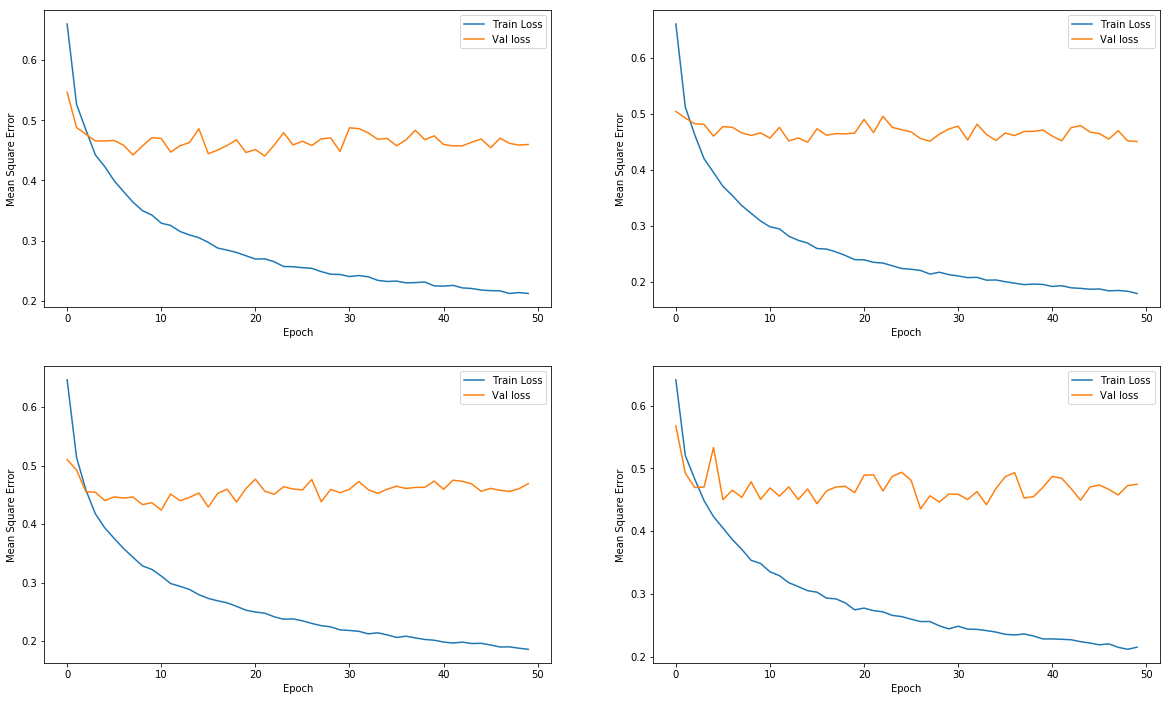

In [19]:
if significance:
    activation = tf.nn.relu
    initializer = None
    regularizer = None
    epochs = 50
    batch_size = 1000
    val_split = 0.2

    datasets = [(x_base, "x_base"), (x_tke, "x_tke"), (x_theta, "x_theta"), (x_p, "x_p")]
    fig = plt.figure(figsize = (20, 12))
    results = {}
    i = 1
    for (x, name) in datasets:
        print("Using " + name + " as input")
        mask =  np.random.rand(x.shape[0]) < 0.80
        y_train, y_test = y_heat1[mask], y_heat1[~mask]
        x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]

        input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
        model = DNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split)        
        history, model = model.run_model()
        
        del x_train
        del y_train
        gc.collect()
        
        fig.add_subplot(2, int(len(datasets) / 2), i)
        plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
        plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error')
        plt.legend()

        y_pred = model.predict(x_test).flatten()
        y_true = y_test
        print("R^2: %.4f" % r2_score(y_true, y_pred))
        print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])
        results[np.corrcoef(y_pred, y_true)[0, 1]] = (x, name)
        
        del x_test
        del y_test
        del x
        del y_true
        del y_pred
        del model
        gc.collect()
        i += 1

    plt.show()

In [20]:
x_best = x_base
del results
gc.collect()

0

Predicting heat1
R^2: 0.7379
Correlation: 0.8872
Saved model to disk

Predicting heat2
R^2: 0.5271
Correlation: 0.7479
Saved model to disk

Predicting heat3
R^2: 0.6953
Correlation: 0.8547
Saved model to disk



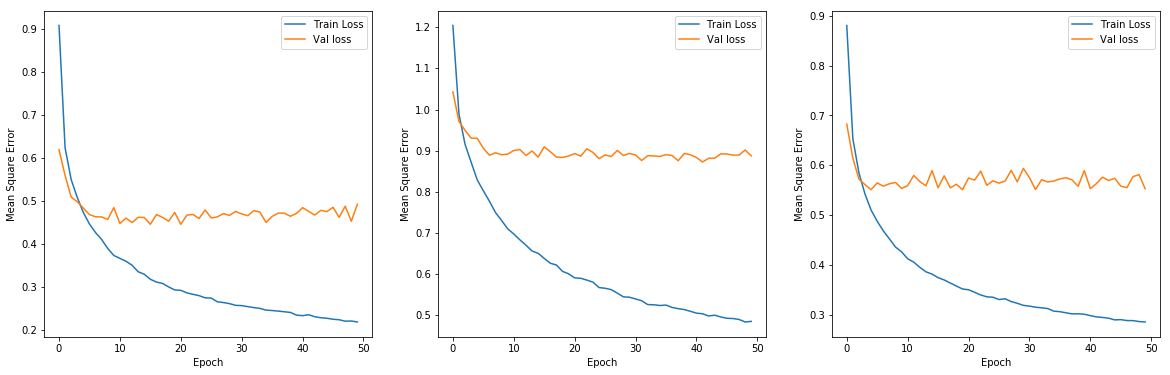

In [22]:
taus = [(y_heat1, "heat1"), (y_heat2, "heat2"), (y_heat3, "heat3")]
    
activation = tf.nn.relu
initializer = None
regularizer = None
epochs = 50
batch_size = 5000
input_shape = (x_base.shape[1], x_base.shape[2], x_base.shape[3], x_base.shape[4])
val_split = 0.2

fig = plt.figure(figsize = (20, 6))

i = 1
for (y, name) in taus:
    print("Predicting " + name)
    mask =  np.random.rand(x_base.shape[0]) < 0.80
    x_train, x_test = x_base[mask,:,:,:,:], x_base[~mask,:,:,:,:]
    y_train, y_test = y[mask], y[~mask]
    
    model = DNN(activation, initializer, regularizer, x_train, y_train, epochs, batch_size, input_shape, val_split)
    history, model = model.run_model()
    
    del x_train
    del y_train
    gc.collect()
    
    fig.add_subplot(1, len(taus), i)
    plt.plot(history.epoch, np.array(history.history['loss']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']), label = 'Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    
    y_pred = model.predict(x_test).flatten()
    y_true = y_test
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f" % np.corrcoef(y_pred, y_true)[0, 1])
    
    model_name_json = "model_" + name + ".json"
    model_name_h5 = "model_" + name + ".h5"
    model_json = model.to_json()
    with open(model_name_json, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name_h5)
    print("Saved model to disk\n")
    
    del x_test
    del y_true
    del y_pred
    del y_test
    del model
    del y
    gc.collect()
    i += 1

plt.show()